In [1]:
import pickle
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
from netCDF4             import Dataset 
from importlib import reload
from pca_all_impute     import *

In [2]:
# read in the 1951-1980 climatological means data and organize them into a list
temps_mean = np.loadtxt('mohsst_mean.tsv')
temps_mean = pd.to_numeric(temps_mean.flatten(), errors='coerce').reshape(temps_mean.shape)
monthly_mean = []
for i in range(12):
    monthly_mean.append(temps_mean[i*180:i*180+180, :])

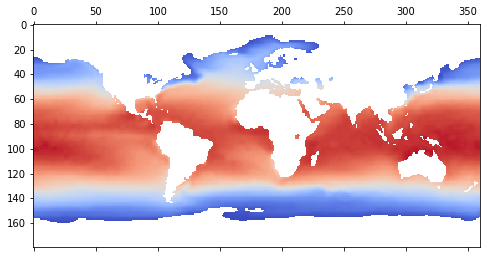

In [3]:
plt.matshow(monthly_mean[0], cmap='coolwarm')
plt.show()

In [4]:
# compress the monthly_mean so that they have the same spacial discretization as the MOHSST dataset
def compress(originalmap):
    compressedmap = np.zeros(shape=(36, 72))
    for i in range(36):
        for j in range(72):
            compressedmap[i, j] = np.nanmean(originalmap[i*5:i*5+5, j*5: j*5+5])
    return compressedmap
for i in range(12):
    monthly_mean[i] = compress(monthly_mean[i])

/Users/chenfeiyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


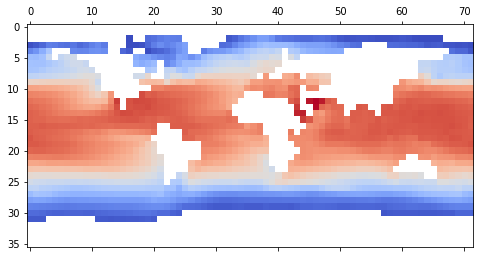

In [5]:
plt.matshow(monthly_mean[7], cmap='coolwarm')
plt.show()

In [6]:
# read in the MOHSST5 dataset and organize them into a numpy array
mohsst = pd.read_csv('mohsst.tsv', delimiter='\t')
temps = mohsst.values

def get_order(year, month):
    return (year-1856)*12 + month
def get_index(order):
    start = (order-1) * 73
    return start, start+72
def get_temp_map(year, month, temps, monthly_mean, flat=False):
    ind1, ind2 = get_index(get_order(year, month))
    str2d = temps[ind1:ind2, 1:].T 
    num1d = pd.to_numeric(str2d.flatten(), errors='coerce') + monthly_mean[month-1].flatten()
    if flat:
        return num1d
    else:
        return num1d.reshape(36, 72)

temp_map_list = []
for year in range(1856, 1992):
    for month in range(1, 13):
        temp_map_list.append(get_temp_map(year, month, temps, monthly_mean, flat=True))
sst_history = np.array(temp_map_list)

In [7]:
# read in the NOAASST dataset and organize them into a numpy array
dataset = Dataset('sst.mnmean.nc')

def get_timeindex_noaasst(year, month):
    return (year-1981)*12 + month-12
def get_latsindex_noaasst(latindex_mohsst):
    start = latindex_mohsst*5
    return start, start+5
def get_lonsindex_noaasst(lonsindex_mohsst):
    start = ( (lonsindex_mohsst+36)%72 ) * 5
    return start, start+5
def get_temp_val(lon_ind, lat_ind, timeindex, var_sst, mean=False):
    lon_lo, lon_hi = get_lonsindex_noaasst(lon_ind)
    lat_lo, lat_hi = get_latsindex_noaasst(lat_ind)
    if mean:
        return np.mean(var_sst[timeindex, lat_lo:lat_hi, lon_lo:lon_hi])
    else:
        return np.array(var_sst[timeindex, lat_lo:lat_hi, lon_lo:lon_hi])

temp_map_list_val = []
for year in range(1982, 1992):
    for month in range(1, 13):
        timeindex = get_timeindex_noaasst(year, month)
        temp_map = np.zeros(shape=(36, 72))
        for lon_ind in range(72):
            for lat_ind in range(36):
                temp_map[lat_ind, lon_ind] = \
                    get_temp_val(lon_ind, lat_ind, timeindex, dataset.variables['sst'], mean=True)
        temp_map_list_val.append(temp_map.flatten())
sst_history_val = np.array(temp_map_list_val)

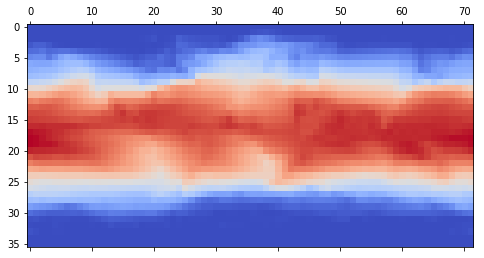

In [8]:
plt.matshow(sst_history_val[-2].reshape(36, 72), cmap='coolwarm')

In [9]:
# give a reconstruction of the SST given the imputed SST data and fitted PCA model
def reestimate(sst_imputed, pcamodel, monthly_mean, month):
    land = np.isnan(monthly_mean[month-1])
    sst_imputed = sst_imputed.reshape(1, -1)
    sst_reest = pcamodel.inverse_transform(pcamodel.transform(sst_imputed)).flatten()
    sst_reest[land.flatten()] = np.nan
    return sst_reest

In [18]:
def mse(map1, map2):
    land = np.isnan(map1)
    map2filtered = map2.copy()
    map2filtered[land] = np.nan
    return np.sqrt(np.nansum((map1-map2filtered)**2))/np.sum(~land)

# calculate the mses of imputed SST
def calc_mses(sst_history_filled, sst_history_val, pcamodel, monthly_mean): 
    mses = []
    for year in range(1982, 1992):
        for month in range(1, 13):
            ind = (year-1991)*12+(month-12)-1
            sst_filled = sst_history_filled[ind]
            sst_reest = reestimate(sst_filled, pcamodel, monthly_mean, month)
            sst_val = sst_history_val[ind]
            mses.append(mse(sst_reest, sst_val))
    return mses
# calculate the mses of the imputed SST by the baseline model
def calc_mses_baseline(sst_history_val, monthly_mean): 
    mses = []
    for year in range(1982, 1992):
        for month in range(1, 13):
            ind = (year-1991)*12+(month-12)-1
            sst_reest = monthly_mean[month-1].flatten()
            sst_val = sst_history_val[ind]
            mses.append(mse(sst_reest, sst_val))
    return mses

In [32]:
pca_imputer = PCAImputer(n_dimension=20, method='ppca')
sst_history_filled, _ = pca_imputer.fit_transform(sst_history, n_iteration=10, cdata=sst_history, tol=0.0)
pcamodel = pca_imputer._pca

In [33]:
mses_ppca20dim_10iter = calc_mses(sst_history_filled, sst_history_val, pcamodel, monthly_mean)

<Figure size 432x288 with 0 Axes>

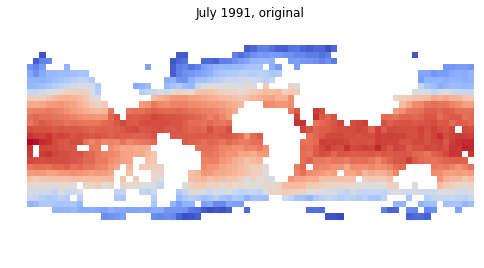

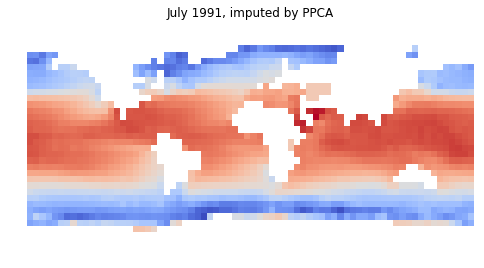

In [34]:
ind = -18
test_sst = sst_history[ind]
test_sst_filled = sst_history_filled[ind]
test_sst_reest = reestimate(test_sst_filled, pcamodel, monthly_mean, 10)
plt.tight_layout()
plt.matshow(sst_history[-3].reshape(36, 72), cmap='coolwarm')
plt.title('July 1991, original')
plt.axis('off')
plt.show()
plt.matshow(test_sst_reest.reshape(36, 72), cmap='coolwarm')
plt.title('July 1991, imputed by PPCA')
plt.axis('off')
plt.show()

In [35]:
pca_imputer = PCAImputer(n_dimension=20, method='pca')
sst_history_filled, _ = pca_imputer.fit_transform(sst_history, n_iteration=10, cdata=sst_history, tol=0.0)
pcamodel = pca_imputer._pca

In [36]:
mses_pca20dim_10iter = calc_mses(sst_history_filled, sst_history_val, pcamodel, monthly_mean)

<Figure size 432x288 with 0 Axes>

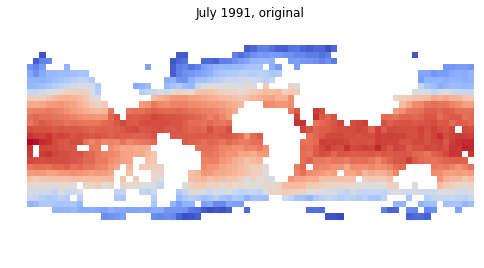

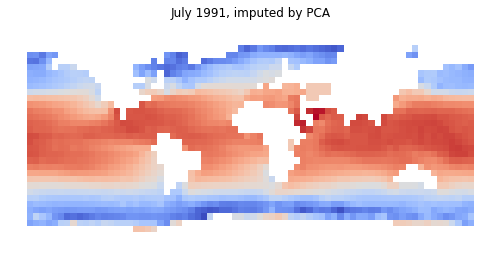

In [37]:
ind = -18
test_sst = sst_history[ind]
test_sst_filled = sst_history_filled[ind]
test_sst_reest = reestimate(test_sst_filled, pcamodel, monthly_mean, 10)
plt.tight_layout()
plt.matshow(sst_history[-3].reshape(36, 72), cmap='coolwarm')
plt.title('July 1991, original')
plt.axis('off')
plt.show()
plt.matshow(test_sst_reest.reshape(36, 72), cmap='coolwarm')
plt.title('July 1991, imputed by PCA')
plt.axis('off')
plt.show()

In [38]:
with open('sst_history_filled.pickle', 'rb') as handle:
    sst_history_filled = pickle.load(handle)
with open('pcamodel.pickle', 'rb') as handle:
    pcamodel = pickle.load(handle)

In [39]:
mses_bpca_5iter = calc_mses(sst_history_filled, sst_history_val, pcamodel, monthly_mean)

<Figure size 432x288 with 0 Axes>

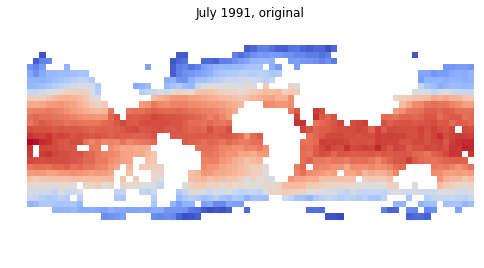

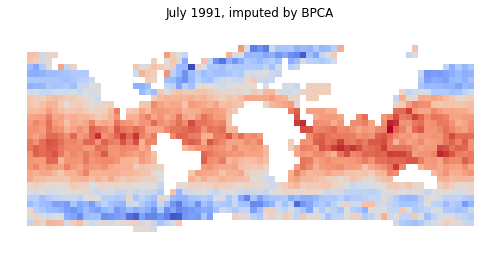

In [43]:
ind = -18
test_sst = sst_history[ind]
test_sst_filled = sst_history_filled[ind]
test_sst_reest = reestimate(test_sst_filled, pcamodel, monthly_mean, 10)
plt.tight_layout()
plt.matshow(sst_history[-3].reshape(36, 72), cmap='coolwarm')
plt.title('July 1991, original')
plt.axis('off')
plt.show()
plt.matshow(test_sst_reest.reshape(36, 72), cmap='coolwarm')
plt.title('July 1991, imputed by BPCA')
plt.axis('off')
plt.show()

In [41]:
baseline = calc_mses_baseline(sst_history_val, monthly_mean)

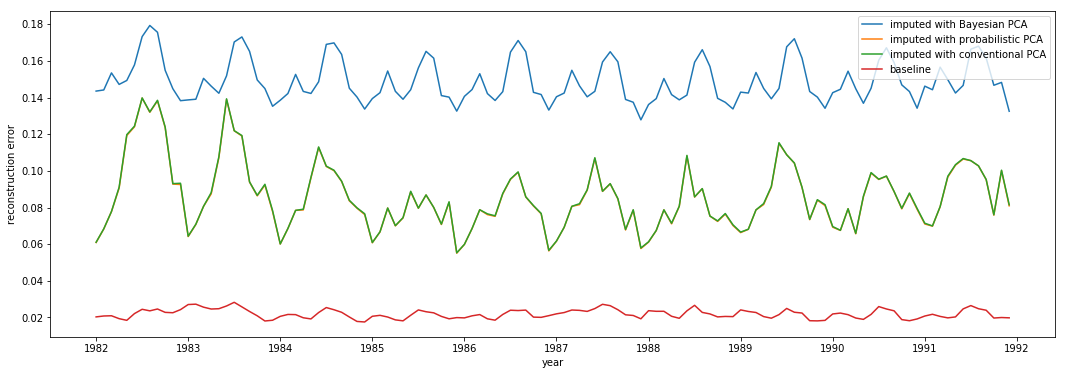

In [42]:
# mses_bpca_5iter = calc_mses(sst_history_filled, sst_history_val, pcamodel, monthly_mean)
plt.figure(figsize=(18, 6))
plt.plot(mses_bpca_5iter,       label='imputed with Bayesian PCA')
plt.plot(mses_ppca20dim_10iter, label='imputed with probabilistic PCA')
plt.plot(mses_pca20dim_10iter,  label='imputed with conventional PCA')
plt.plot(baseline,              label='baseline')
plt.xticks(np.linspace(0, 120, 11), np.arange(1982, 1993))
plt.xlabel('year')
plt.ylabel('reconstruction error')
plt.legend()
plt.show()